In [ ]:
import math as mh
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For visualizations
import seaborn as sns
import matplotlib.pyplot as plt
% config InlineBackend.figure_format = 'png'
% matplotlib inline

In [27]:
# For data parsing
from datetime import datetime

# For choosing attributes that have good gaussian distribution
from scipy.stats import shapiro

# Needed for getting parameters for models
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Models
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn import cluster
from sklearn.neighbors import KNeighborsClassifier

# For scaling/normalizing values
from sklearn.preprocessing import MinMaxScaler

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [4]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print("Train :",train.shape)
print("Test:",test.shape)

Train : (137, 43)
Test: (100000, 42)


In [5]:
# Calculate number of samples in training and test datasets
num_train = train.shape[0]
num_test = test.shape[0]
print(num_train, num_test)

# For feature engineering, combine train and test data
data = pd.concat((train.loc[:, "Open Date" : "P37"],
                  test.loc[:, "Open Date" : "P37"]), ignore_index=True)

137 100000


In [6]:
data.tail()

,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
100132,01/05/2000,Antalya,Other,FC,5,5.0,4.0,4.0,2,2,...,2.0,3.0,0,0,0,0,0,0,0,0
100133,07/18/2011,Niğde,Other,IL,1,2.0,4.0,3.0,1,1,...,1.0,3.0,5,0,0,0,4,0,0,0
100134,12/29/2012,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,2,...,4.0,1.0,5,5,3,2,4,4,4,2
100135,10/12/2013,İstanbul,Big Cities,FC,12,7.5,6.0,6.0,4,4,...,7.5,5.0,0,0,0,4,0,0,0,0
100136,10/05/2010,İstanbul,Big Cities,IL,2,5.0,4.0,4.0,2,2,...,5.0,3.0,0,2,0,2,2,4,2,0


In [7]:
#Get name of all headers of data frame
#list(data)
data.columns.values.tolist()

['Open Date',
 'City',
 'City Group',
 'Type',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17',
 'P18',
 'P19',
 'P20',
 'P21',
 'P22',
 'P23',
 'P24',
 'P25',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'P31',
 'P32',
 'P33',
 'P34',
 'P35',
 'P36',
 'P37']

**Check for Missing values and plot for each column**

Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
dtype: int64


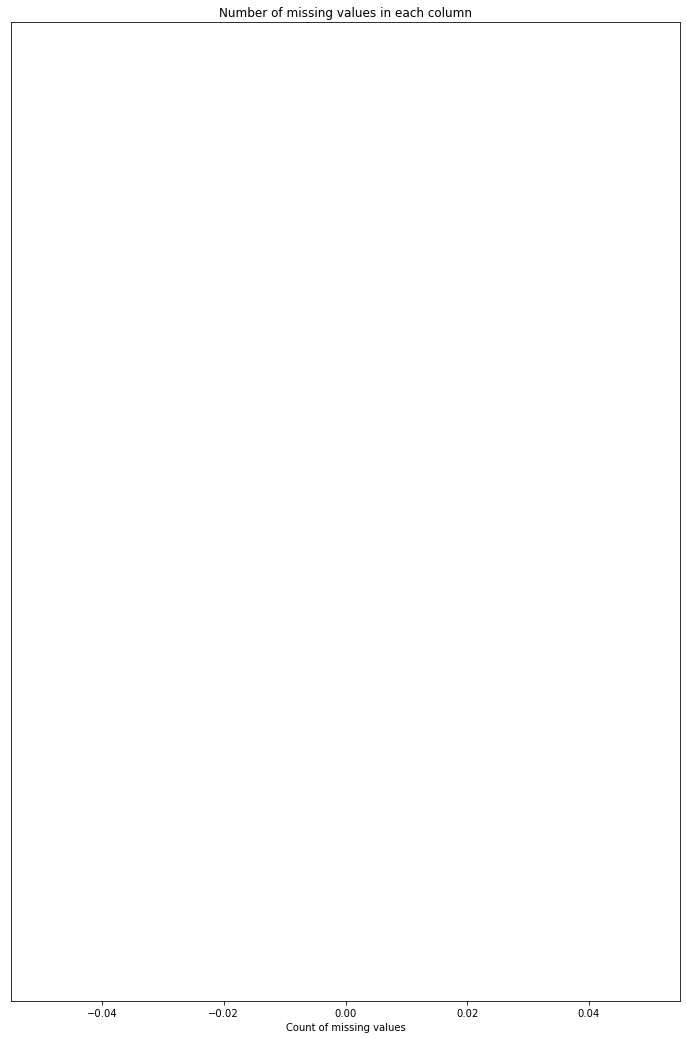

In [8]:
print(data.isnull().sum().T) #No null values in any column, so no imputation and removal of rows
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [9]:
# Convert date to days
# Have to drop date 
import time
from datetime import datetime as dt
# train
all_diff = []
for date in data["Open Date"]:
    diff = dt.now() - dt.strptime(date, "%m/%d/%Y")
    all_diff.append(int(diff.days/1000))

data['Days_from_open'] = pd.Series(all_diff)
print(data.head())

    Open Date        City  City Group Type  P1   P2   P3   P4  P5  P6  ...  \
0  07/17/1999    İstanbul  Big Cities   IL   4  5.0  4.0  4.0   2   2  ...   
1  02/14/2008      Ankara  Big Cities   FC   4  5.0  4.0  4.0   1   2  ...   
2  03/09/2013  Diyarbakır       Other   IL   2  4.0  2.0  5.0   2   3  ...   
3  02/02/2012       Tokat       Other   IL   6  4.5  6.0  6.0   4   4  ...   
4  05/09/2009   Gaziantep       Other   IL   3  4.0  3.0  4.0   2   2  ...   

   P29  P30  P31  P32  P33  P34  P35  P36  P37  Days_from_open  
0  3.0    5    3    4    5    5    4    3    4               7  
1  3.0    0    0    0    0    0    0    0    0               4  
2  3.0    0    0    0    0    0    0    0    0               2  
3  7.5   25   12   10    6   18   12   12    6               3  
4  3.0    5    1    3    2    3    4    3    3               4  

[5 rows x 42 columns]


In [10]:
#Drop Open Date Column
data = data.drop('Open Date', axis=1)

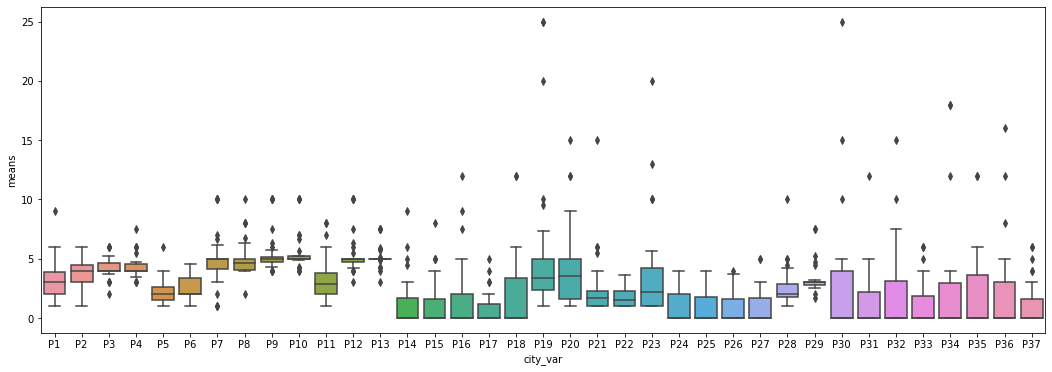

In [11]:
# Plotting mean of P-variables over each city helps us see which P-variables are highly related to City
# since we are given that one class of P-variables is geographical attributes.
distinct_cities = train.loc[:, "City"].unique()

# Get the mean of each p-variable for each city
means = []
for col in train.columns[5:42]:
    temp = []
    for city in distinct_cities:
        temp.append(train.loc[train.City == city, col].mean())     
    means.append(temp)
    
# Construct data frame for plotting
city_pvars = pd.DataFrame(columns=["city_var", "means"])
for i in range(37):
    for j in range(len(distinct_cities)):
        city_pvars.loc[i+37*j] = ["P"+str(i+1), means[i][j]]
        
# Plot boxplot
plt.rcParams['figure.figsize'] = (18.0, 6.0)
sns.boxplot(x="city_var", y="means", data=city_pvars)

# From this we observe that P1, P2, P11, P19, P20, P23, and P30 are approximately a good
# proxy for geographical location.

In [15]:
# K Means treatment for city (mentioned in the paper)
def adjust_cities(data, train, k):
    
    # As found by box plot of each city's mean over each p-var
    relevant_pvars =  ["P1", "P2", "P11", "P19", "P20", "P23", "P30"]
    train = train.loc[:, relevant_pvars]
    
    # Optimal k is 20 as found by DB-Index plot    
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(train)
    
    # Get the cluster centers and classify city of each data instance to one of the centers
    data['City Cluster'] = kmeans.predict(data.loc[:, relevant_pvars])
    del data["City"]
    
    return data

# Convert unknown cities in test data to clusters based on known cities using KMeans
data = adjust_cities(data, train, 20)

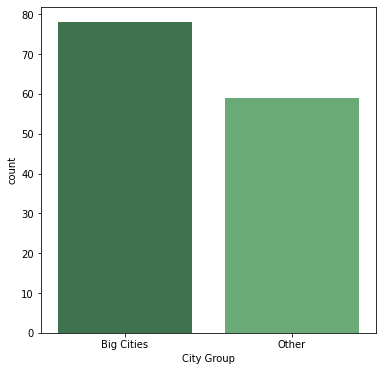

In [16]:
# The two categories of City Group both appear very frequently
plt.rcParams['figure.figsize'] = (6.0, 6.0)
sns.countplot(x='City Group', data=train, palette="Greens_d")

In [17]:
# One hot encode City Group
data = data.join(pd.get_dummies(data['City Group'], prefix="CG"))

# Since only n-1 columns are needed to binarize n categories, drop one of the new columns.  
# And drop the original columns.
data = data.drop(["City Group", "CG_Other"], axis=1)

In [18]:
#Check the data type of all columns
data.dtypes

Type               object
P1                  int64
P2                float64
P3                float64
P4                float64
P5                  int64
P6                  int64
P7                  int64
P8                  int64
P9                  int64
P10                 int64
P11                 int64
P12                 int64
P13               float64
P14                 int64
P15                 int64
P16                 int64
P17                 int64
P18                 int64
P19                 int64
P20                 int64
P21                 int64
P22                 int64
P23                 int64
P24                 int64
P25                 int64
P26               float64
P27               float64
P28               float64
P29               float64
P30                 int64
P31                 int64
P32                 int64
P33                 int64
P34                 int64
P35                 int64
P36                 int64
P37                 int64
Days_from_op

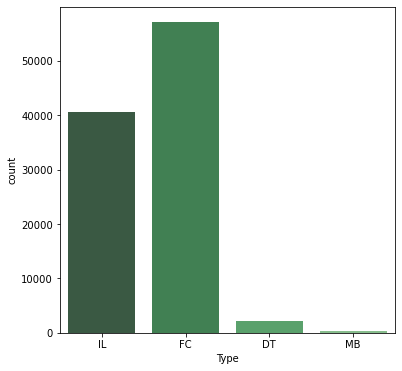

In [19]:
#Check the type column 
# Two of the four Restaurant Types (DT and MB), are extremely rare
sns.countplot(x='Type', data=data, palette="Greens_d")

In [20]:
# One hot encode Restaurant Type
data = data.join(pd.get_dummies(data['Type'], prefix="T"))
 
# Drop the original column
data = data.drop(["Type"], axis=1)

In [21]:
data.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P35,P36,P37,Days_from_open,City Cluster,CG_Big Cities,T_DT,T_FC,T_IL,T_MB
0,4,5.0,4.0,4.0,2,2,5,4,5,5,...,4,3,4,7,4,1,0,0,1,0
1,4,5.0,4.0,4.0,1,2,5,5,5,5,...,0,0,0,4,13,1,0,1,0,0
2,2,4.0,2.0,5.0,2,3,5,5,5,5,...,0,0,0,2,0,0,0,0,1,0
3,6,4.5,6.0,6.0,4,4,10,8,10,10,...,12,12,6,3,12,0,0,0,1,0
4,3,4.0,3.0,4.0,2,2,5,5,5,5,...,4,3,3,4,11,0,0,0,1,0


In [22]:
#Count distinct values for each column in Data frame
data.apply(lambda x: len(x.unique()))

P1                 9
P2                 9
P3                 8
P4                 7
P5                 7
P6                 8
P7                 7
P8                 8
P9                 5
P10                4
P11                8
P12                7
P13                5
P14               10
P15                9
P16               10
P17               10
P18                9
P19                9
P20                9
P21                9
P22                5
P23                9
P24                9
P25                9
P26               10
P27               10
P28                9
P29                8
P30               10
P31               10
P32               10
P33                7
P34               11
P35                8
P36               10
P37                8
Days_from_open     8
City Cluster      20
CG_Big Cities      2
T_DT               2
T_FC               2
T_IL               2
T_MB               2
dtype: int64

In [28]:
# Scale all input features to between 0 and 1.
min_max_scaler = MinMaxScaler()
data = pd.DataFrame(data=min_max_scaler.fit_transform(data),columns=data.columns, index=data.index)

In [29]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


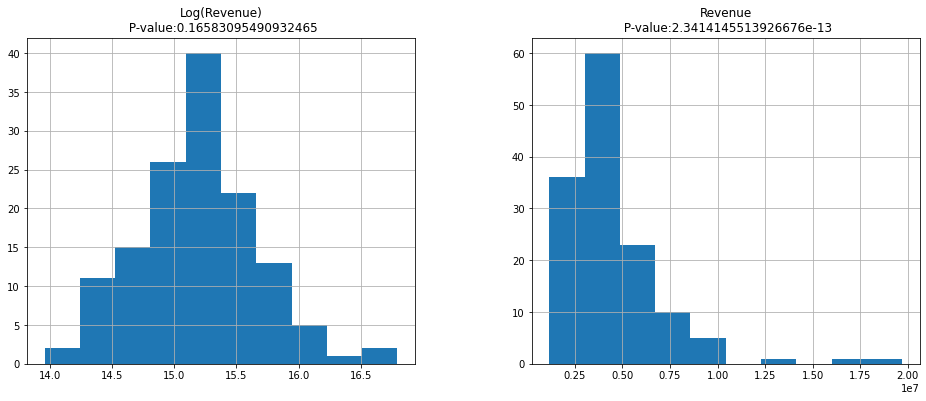

In [30]:
#Revenue Distribution of Train Set
# Check distribution of revenue and log(revenue) (Other Transformation could be Sqrt Transformation)
plt.rcParams['figure.figsize'] = (16.0, 6.0)
pvalue_before = shapiro(train["revenue"])[1]
pvalue_after = shapiro(np.log(train["revenue"]))[1]
graph_data = pd.DataFrame(
        {
            ("Revenue\n P-value:" + str(pvalue_before)) : train["revenue"],
            ("Log(Revenue)\n P-value:" + str(pvalue_after)) : np.log(train["revenue"])
        }
    )
graph_data.hist()

#Shapiro Wilks test for normality
# log transform revenue as it is approximately normal. If this distribution for revenue holds in the test set,
# log transforming the variable before training models will improve performance vastly.
# However, we cannot be completely certain that this distribution will hold in the test set.
train["revenue"] = np.log(train["revenue"])

In [31]:
# Split into train and test datasets
train_processed = data[:num_train]
test_processed = data[num_train:]

In [35]:
from sklearn import linear_model, ensemble
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.svm import SVR

regr = linear_model.LinearRegression()
regr.get_params()

C:\Users\Aniket.Rele\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.linear_model.stochastic_gradient module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
# build model
from sklearn import linear_model,ensemble
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.svm import SVR

# simple regression
print("Simple regression")

#create linear regression model object
regr = linear_model.LinearRegression()
#regr.get_params() -- Check the list of paramters for the given model

# create a parameter grid: map the parameter names to the values that should be searched
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

def RMSE(y_true,y_pred):
    rmse = mh.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE: %2.3f' % rmse)
    return rmse

'''def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print('R2: %2.3f' % r2)
     return r2
'''
    
def two_score(y_true,y_pred):
    score = RMSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    #score = R2(y_true,y_pred)
    return score

my_score = make_scorer(two_score, greater_is_better=False) # change for false if using MSE

# instantiate the grid
grid = GridSearchCV(regr, parameters, cv=LeaveOneOut())

# fit the grid with data
grid.fit(train_processed, train["revenue"])

# Re-train on full training set using the best parameters found in the last step.
# examine the best model
print("Best score :",grid.best_score_)
print("Best params :",grid.best_params_)
print("Best estimator:",grid.best_estimator_)
regr.set_params(**grid.best_params_)
regr.fit(train_processed, train["revenue"])

# results
results_regr = regr.predict(test_processed)
results_regr_exp=np.exp(results_regr)
print(results_regr_exp)

Simple regression
Best score : nan
Best params : {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Best estimator: LinearRegression(normalize=True)
[5138153.94568237 2582903.28725565 2778264.57341282 ... 4942559.88190243
 6706956.07758788 4780466.71630068]


In [41]:
submission_lin_reg = pd.DataFrame(columns=['Prediction'],index=test.index, data=results_regr_exp)
submission_lin_reg.index.name = 'Id'

In [42]:
submission_lin_reg.describe().astype(int)

,Prediction
count,100000
mean,6656681
std,23000021
min,6702
25%,2856341
50%,4068098
75%,6045713
max,-2147483648


In [43]:
# Ridge model
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
ridge_clf = Ridge()

# Use a grid search and leave-one-out CV on the train set to find the best regularization parameter to use.
grid = GridSearchCV(ridge_clf, model_grid, cv=LeaveOneOut())
grid.fit(train_processed, train["revenue"])

# Re-train on full training set using the best parameters found in the last step.
# examine the best model
print("Best score :",grid.best_score_)
print("Best params :",grid.best_params_)
print("Best estimator:",grid.best_estimator_)
ridge_clf.set_params(**grid.best_params_)
ridge_clf.fit(train_processed, train["revenue"])

# results_ridge = np.exp(ridge_clf.predict(test_processed))
results_ridge = ridge_clf.predict(test_processed)
results_ridge_exp=np.exp(results_ridge)
print(results_ridge_exp)

Best score : nan
Best params : {'alpha': 1.0, 'normalize': True}
Best estimator: Ridge(normalize=True)
[3918402.54803536 3614081.54030424 3920988.04142264 ... 4049250.84476784
 4299999.43343835 3793936.38463242]


In [44]:
# Lasso model
model_grid = [{'normalize': [True, False], 'alpha': np.logspace(0,10)}]
lasso_clf = Lasso()

# Use a grid search and leave-one-out CV on the train set to find the best regularization parameter to use.
grid = GridSearchCV(lasso_clf, model_grid, cv=LeaveOneOut())
grid.fit(train_processed, train["revenue"])

# Re-train on full training set using the best parameters found in the last step.
print("Best score :",grid.best_score_)
print("Best params :",grid.best_params_)
print("Best estimator:",grid.best_estimator_)
lasso_clf.set_params(**grid.best_params_)
lasso_clf.fit(train_processed, train["revenue"])

#Predict the test set
results_lasso = lasso_clf.predict(test_processed)
results_lasso_exp = np.exp(results_lasso)
print(results_lasso_exp)

Best score : nan
Best params : {'alpha': 1.0, 'normalize': True}
Best estimator: Lasso(normalize=True)
[3941975.68112035 3941975.68112035 3941975.68112035 ... 3941975.68112035
 3941975.68112035 3941975.68112035]


In [45]:
#SVR()
from sklearn.svm import SVR, LinearSVR

svr = SVR(C=1, epsilon=0.1)
svr.fit(train_processed, train["revenue"])
results_svm = svr.predict(test_processed)
results_svm_exp = np.exp(results_svm)
print(results_svm_exp)

[4025394.54913642 2955953.86763557 2870199.14772998 ... 4500684.9351339
 4790915.63766092 3428741.75369285]
